# **Análise de Atrasos em Voos nos EUA**

Este projeto tem como objetivo construir um pipeline de dados utilizando a plataforma Databricks e ferramentas locais como Python, Jupyter e GitHub. A proposta é investigar padrões de atrasos aéreos nos Estados Unidos a partir de um conjunto de dados público disponibilizado pelo Kaggle. 

A análise será orientada pelas perguntas de negócio previamente definidas no README e executada de forma documentada, com foco em atender todos os critérios de avaliação propostos no desenvolvimento do MVP.


### **Perguntas de Negócio**
- Quais companhias aéreas apresentam maior proporção de voos com atraso?
- Existe relação entre o horário do voo e a ocorrência de atrasos?
- A distância ou o tempo de voo influenciam o atraso na chegada?
- Quais aeroportos concentram mais atrasos na decolagem e/ou chegada?
- Há diferenças relevantes na frequência de atrasos por dia da semana ou mês?

Essas perguntas guiarão tanto a análise exploratória quanto a modelagem preditiva, contribuindo para a identificação de padrões relevantes que expliquem os atrasos nos voos.

## **Setup Inicial**

In [58]:
# Importação inicial das bibliotecas essenciais para análise
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# Configurações de exibição
pd.set_option('display.max_columns', 100)
sns.set(style="whitegrid")


## **Carregamento dos Dados**

O notebook utiliza o arquivo `flights_amostra.csv`, uma versão reduzida com 20.000 registros aleatórios, gerada a partir do dataset original `flights.csv` (aproximadamente 580 MB), disponibilizado publicamente no Kaggle, que foi utilizado apenas localmente.

Devido às limitações de tamanho do GitHub, o arquivo completo não foi incluído no repositório.  
A amostra é suficiente para todas as análises previstas no projeto e está disponível para execução reprodutível.

Abaixo está o código utilizado para carregar a amostra.  
O trecho responsável pela geração do arquivo está comentado, pois foi executado previamente.


In [59]:
# A linha abaixo foi executada localmente e não é necessária para rodar o notebook:
# df = pd.read_csv('data/flights.csv', low_memory=False)
# amostra = df.sample(n=20000, random_state=42)
# amostra.to_csv("data/flights_amostra.csv", index=False)

# Carregando a versão reduzida (disponível no repositório)
df = pd.read_csv('data/flights_amostra.csv', low_memory=False)

# Visualizando as primeiras linhas
df.head()


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,4,7,2,EV,4900,N759EV,FWA,DTW,1340,1335.0,-5.0,13.0,1348.0,56.0,48.0,30.0,128,1418.0,5.0,1436,1423.0,-13.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,24,6,AS,611,N413AS,LAS,SEA,1910,1858.0,-12.0,14.0,1912.0,155.0,155.0,131.0,867,2123.0,10.0,2145,2133.0,-12.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,7,8,3,WN,1483,N463WN,OAK,SEA,630,626.0,-4.0,8.0,634.0,110.0,106.0,92.0,672,806.0,6.0,820,812.0,-8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,5,26,2,WN,193,N7745A,STL,DAL,810,1043.0,153.0,6.0,1049.0,100.0,99.0,85.0,546,1214.0,8.0,950,1222.0,152.0,0,0,NaN,0.0,0.0,0.0,152.0,0.0
4,2015,7,6,1,UA,253,N213UA,IAH,HNL,1000,1008.0,8.0,16.0,1024.0,498.0,488.0,461.0,3904,1305.0,11.0,1318,1316.0,-2.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## **Dimensões do Conjunto de Dados e Tipos de Variáveis**

Abaixo verifico a quantidade de linhas e colunas, além dos tipos de dados presentes. Isso me ajuda a entender a complexidade e possíveis etapas de tratamento necessárias.


In [60]:
print(f"Número de linhas: {df.shape[0]}")
print(f"Número de colunas: {df.shape[1]}")

print("\nInfo Amostra:")
df.info()

Número de linhas: 20000
Número de colunas: 31

Info Amostra:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 20000 non-null  int64  
 1   MONTH                20000 non-null  int64  
 2   DAY                  20000 non-null  int64  
 3   DAY_OF_WEEK          20000 non-null  int64  
 4   AIRLINE              20000 non-null  object 
 5   FLIGHT_NUMBER        20000 non-null  int64  
 6   TAIL_NUMBER          19948 non-null  object 
 7   ORIGIN_AIRPORT       20000 non-null  object 
 8   DESTINATION_AIRPORT  20000 non-null  object 
 9   SCHEDULED_DEPARTURE  20000 non-null  int64  
 10  DEPARTURE_TIME       19722 non-null  float64
 11  DEPARTURE_DELAY      19722 non-null  float64
 12  TAXI_OUT             19708 non-null  float64
 13  WHEELS_OFF           19708 non-null  float64
 14  SCHEDULED_TIME       2000

## **Reclassificação e Tratamento de Variáveis**

Após a verificação inicial da estrutura do dataset, identifiquei algumas colunas que, embora estejam tipadas como numéricas, não devem ser tratadas como variáveis quantitativas. Para garantir a integridade das análises estatísticas e facilitar o entendimento dos dados, realizarei os seguintes tratamentos:

- `FLIGHT_NUMBER`: representa o identificador do voo e não possui valor numérico significativo. Será convertido para `string`.

- `YEAR`: coluna com valor constante (2015), não contribui para análise e será removida.

- `CANCELLED` e `DIVERTED`: variáveis binárias que indicam status (0 = não, 1 = sim). Serão convertidas para o tipo `category`.

- `DAY`, `MONTH`, `DAY_OF_WEEK`: representam informações de calendário. Embora numéricas, não são contínuas e também serão convertidas para `category`.

- `ARRIVAL_TIME`, `WHEELS_ON`, `SCHEDULED_ARRIVAL`, `WHEELS_OFF`, `DEPARTURE_TIME`, `SCHEDULED_DEPARTURE`: estão codificadas como inteiros no formato `HHMM`. Para possibilitar análises temporais adequadas e evitar distorções estatísticas, essas colunas serão convertidas para o tipo `datetime.time`, utilizando `pd.to_datetime` com o formato `%H%M`.

Todas as transformações são fundamentais para garantir uma análise estatística coerente e alinhada ao propósito do projeto.


In [61]:
# Remoção da coluna constante
df.drop(columns=['YEAR'], inplace=True)

# Conversão de identificador para string
df['FLIGHT_NUMBER'] = df['FLIGHT_NUMBER'].astype(str)

# Conversão de variáveis categóricas
cols_categoricas = ['CANCELLED', 'DIVERTED', 'DAY', 'MONTH', 'DAY_OF_WEEK']
df[cols_categoricas] = df[cols_categoricas].astype('category')

# Conversão de horários no formato HHMM para datetime.time
colunas_horario = [
    'ARRIVAL_TIME', 'WHEELS_ON', 'SCHEDULED_ARRIVAL',
    'WHEELS_OFF', 'DEPARTURE_TIME', 'SCHEDULED_DEPARTURE'
]

for coluna in colunas_horario:
    df[coluna] = pd.to_datetime(df[coluna], format='%H%M', errors='coerce').dt.time


## **Verificação de Valores Ausentes**

Agora avalio a presença de valores nulos no dataset.  
Essa verificação é essencial para identificar colunas que podem demandar tratamento ou exclusão, e orientar a estratégia de preparação dos dados.


In [62]:
# Verificando valores ausentes
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Valores Nulos': missing_values,
    'Porcentagem (%)': missing_percent.round(2)
})

# Exibindo apenas colunas com valores nulos
missing_df[missing_df['Valores Nulos'] > 0].sort_values(by='Porcentagem (%)', ascending=False)


,Valores Nulos,Porcentagem (%)
CANCELLATION_REASON,19706,98.53
SECURITY_DELAY,16267,81.34
WEATHER_DELAY,16267,81.34
AIR_SYSTEM_DELAY,16267,81.34
LATE_AIRCRAFT_DELAY,16267,81.34
AIRLINE_DELAY,16267,81.34
ARRIVAL_TIME,389,1.94
WHEELS_ON,383,1.92
ELAPSED_TIME,337,1.68
ARRIVAL_DELAY,337,1.68


### **Análise de Valores Ausentes**

Com base na análise de valores nulos, observei que:

- A coluna `CANCELLATION_REASON` possui mais de 98% de valores ausentes, o que é esperado, já que a maioria dos voos **não foi cancelada**;
- As colunas relacionadas a atrasos (`AIR_SYSTEM_DELAY`, `SECURITY_DELAY`, `WEATHER_DELAY`, etc.) têm cerca de 81% de valores nulos, o que também é coerente, pois esses campos só são preenchidos **em caso de atraso**;
- Há colunas como `ARRIVAL_DELAY`, `AIR_TIME`, `TAXI_IN`, `DEPARTURE_TIME` com cerca de 1,5% de valores nulos — essas poderão demandar tratamento ou exclusão conforme o impacto na análise;
- Apenas a coluna `TAIL_NUMBER` apresenta uma taxa baixa de nulos (0,26%) e pode ser mantida sem grandes implicações.

Essas informações serão consideradas na etapa de tratamento de dados.


## **Estatísticas Descritivas**

Nesta etapa, aplico a função `describe()` para obter um resumo estatístico das variáveis numéricas do dataset.  
Esse resumo nos fornece informações importantes como média, desvio padrão, valores mínimo e máximo, e percentis, ajudando a identificar a presença de outliers e a dispersão dos dados.  
Esses insights são fundamentais para orientar as futuras etapas de limpeza e modelagem, garantindo a robustez das análises.


In [63]:
# Estatísticas descritivas para variáveis numéricas
df.describe().T.sort_values(by="std", ascending=False)


,count,mean,std,min,25%,50%,75%,max
DISTANCE,20000.0,824.611350,610.187120,31.0,373.0,647.0,1067.0,4983.0
SCHEDULED_TIME,20000.0,142.163650,75.575541,20.0,86.0,123.0,174.0,680.0
ELAPSED_TIME,19663.0,137.394853,74.441223,22.0,83.0,119.0,169.0,676.0
AIR_TIME,19663.0,113.824137,72.464148,9.0,61.0,95.0,144.0,647.0
AIRLINE_DELAY,3733.0,17.882668,44.855158,0.0,0.0,2.0,18.0,947.0
LATE_AIRCRAFT_DELAY,3733.0,22.861773,41.284678,0.0,0.0,3.0,29.0,470.0
ARRIVAL_DELAY,19663.0,4.190002,37.137156,-62.0,-13.0,-5.0,8.0,947.0
DEPARTURE_DELAY,19722.0,9.155968,34.781251,-36.0,-5.0,-2.0,8.0,965.0
AIR_SYSTEM_DELAY,3733.0,13.065631,24.811103,0.0,0.0,2.0,18.0,292.0
WEATHER_DELAY,3733.0,2.803375,16.899962,0.0,0.0,0.0,0.0,302.0


### **Interpretação das Estatísticas Descritivas**

A análise estatística das variáveis numéricas revelou alguns padrões importantes:

- As colunas com maior desvio padrão são `FLIGHT_NUMBER`, `DISTANCE` e variáveis de horário (`ARRIVAL_TIME`, `WHEELS_ON`, `SCHEDULED_ARRIVAL`), o que é esperado dado a variabilidade natural entre voos e rotas;
- Variáveis relacionadas a atrasos (`AIRLINE_DELAY`, `ARRIVAL_DELAY`, `DEPARTURE_DELAY`) apresentam **altos valores máximos**, sugerindo a presença de **outliers significativos**;
- As colunas `DEPARTURE_TIME`, `WHEELS_OFF`, `SCHEDULED_DEPARTURE` também apresentam alta dispersão, coerente com diferentes horários de operação;
- As colunas `CANCELLED` e `DIVERTED` têm médias próximas de zero, indicando baixa incidência desses eventos;
- A coluna `YEAR` é constante, com valor 2015, e pode ser descartada sem prejuízo para a análise;
- Algumas colunas como `SECURITY_DELAY` têm média e desvio padrão extremamente baixos, sugerindo baixa relevância analítica.

Essas observações são importantes para futuras etapas de:
- **Tratamento de outliers**
- **Remoção de colunas irrelevantes**
- **Normalização ou padronização, se necessário**


## **Análise Exploratória dos Dados**

Nesta etapa, realizarei uma análise exploratória para investigar padrões, distribuições e relações entre as variáveis do conjunto de dados.

A análise será estruturada nos seguintes blocos:
- Distribuição geral das variáveis numéricas
- Identificação de outliers via boxplots
- Análise de distribuição por período (mês, dia da semana)
- Comparação de atrasos por categoria
- Correlação entre variáveis
- Relações com cancelamentos e voos desviados

Esses insights são fundamentais para orientar as futuras etapas de limpeza e modelagem.


### **Distribuição Geral das Variáveis Numéricas**

Abaixo estão os histogramas das principais variáveis numéricas do conjunto de dados. Eles ajudam a entender a distribuição dos dados, presença de assimetrias e padrões importantes.


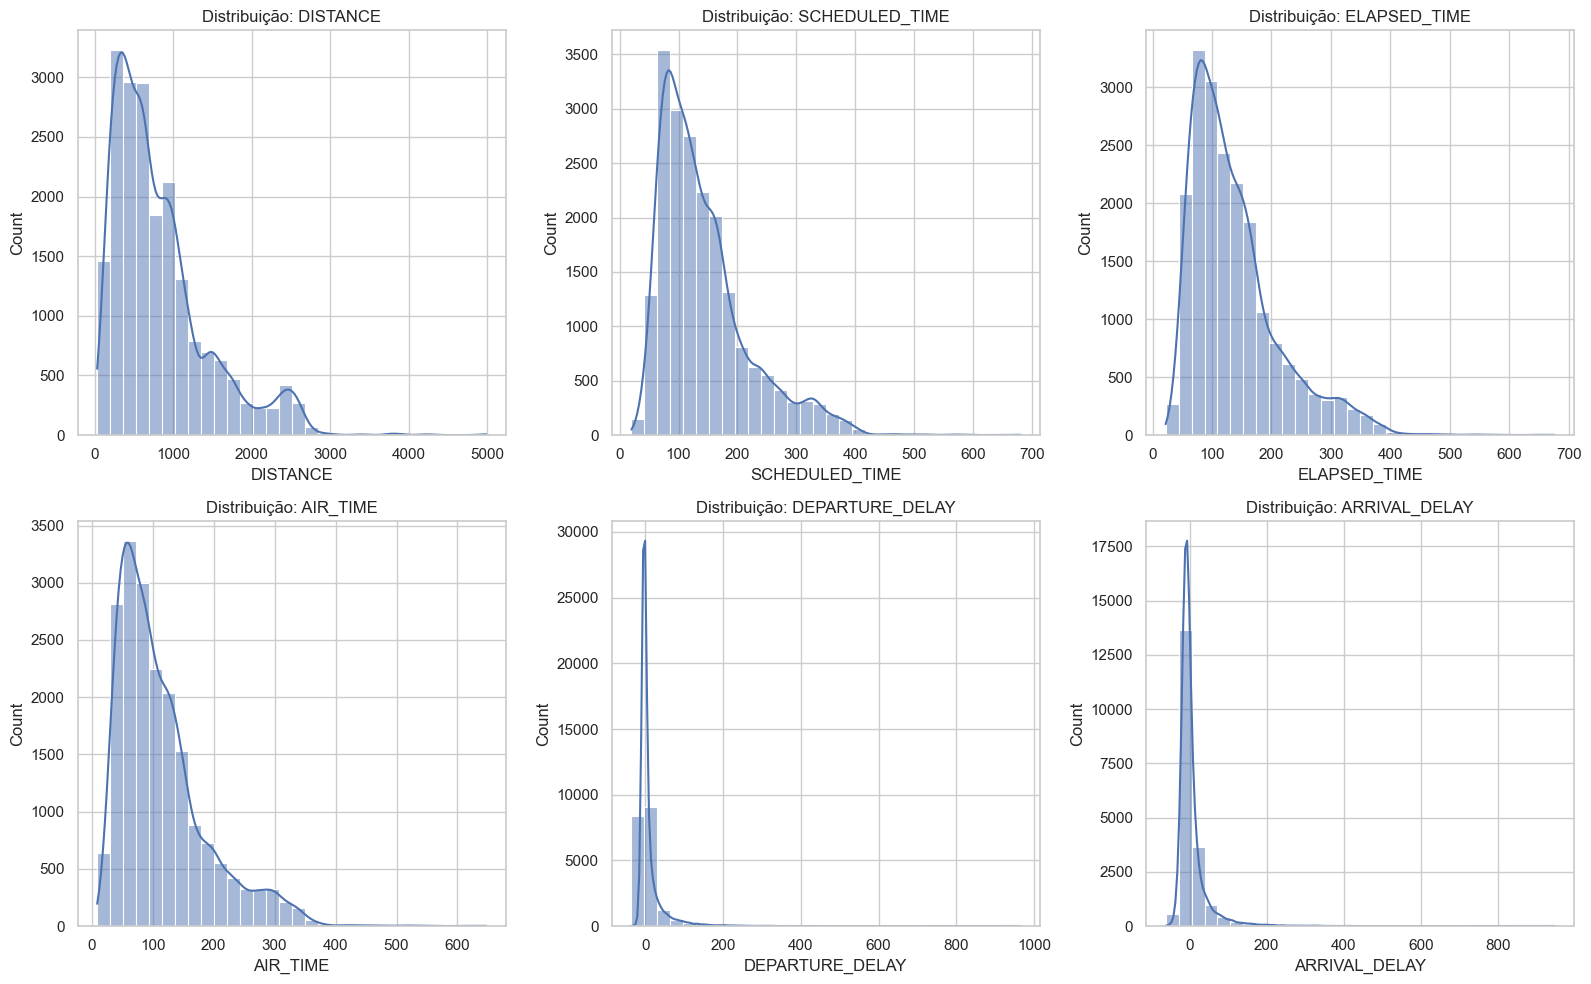

In [64]:
# Selecionando as principais variáveis numéricas para visualização
variaveis_numericas = [
    'DISTANCE', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME',
    'DEPARTURE_DELAY', 'ARRIVAL_DELAY'
]

# Plotando histogramas
plt.figure(figsize=(16, 10))
for i, coluna in enumerate(variaveis_numericas, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[coluna], kde=True, bins=30)
    plt.title(f'Distribuição: {coluna}')
plt.tight_layout()
plt.show()


### **Interpretação dos Histogramas**

A análise dos histogramas revelou padrões importantes nas distribuições das variáveis numéricas:

- Todas as variáveis apresentam **assimetria à direita**, com a maioria dos valores concentrados nas faixas inferiores e uma cauda longa com valores extremos;
- Os atrasos de partida (`DEPARTURE_DELAY`) e chegada (`ARRIVAL_DELAY`) possuem **picos próximos a zero**, sugerindo que a maioria dos voos tem atrasos pequenos, mas alguns casos isolados têm valores altos e potencialmente atípicos;
- As variáveis de tempo e distância (`DISTANCE`, `SCHEDULED_TIME`, `ELAPSED_TIME`, `AIR_TIME`) indicam que a maioria dos voos é de curta a média duração, com alguns poucos voos significativamente mais longos.

Essas observações serão fundamentais para as etapas seguintes de:
- Identificação e tratamento de outliers;
- Normalização, se necessário;
- Engenharia de atributos.


### **Análise de Variáveis Categóricas**

Nesta etapa, exploro variáveis categóricas para identificar padrões sazonais, comportamentos específicos de companhias aéreas e eventos raros que possam afetar os atrasos.

As variáveis analisadas incluem:
- **CANCELLED** e **DIVERTED**: indicam voos cancelados ou desviados;
- **AIRLINE**: representa a companhia aérea responsável;
- **MONTH** e **DAY_OF_WEEK**: permitem avaliar possíveis padrões sazonais ou comportamentos específicos por dia da semana.

A seguir, são apresentados gráficos de contagem para verificar a distribuição dessas categorias. Para as variáveis `CANCELLED` e `DIVERTED`, a distribuição é extremamente desbalanceada, então apresento a **proporção (%)** para melhor compreensão.


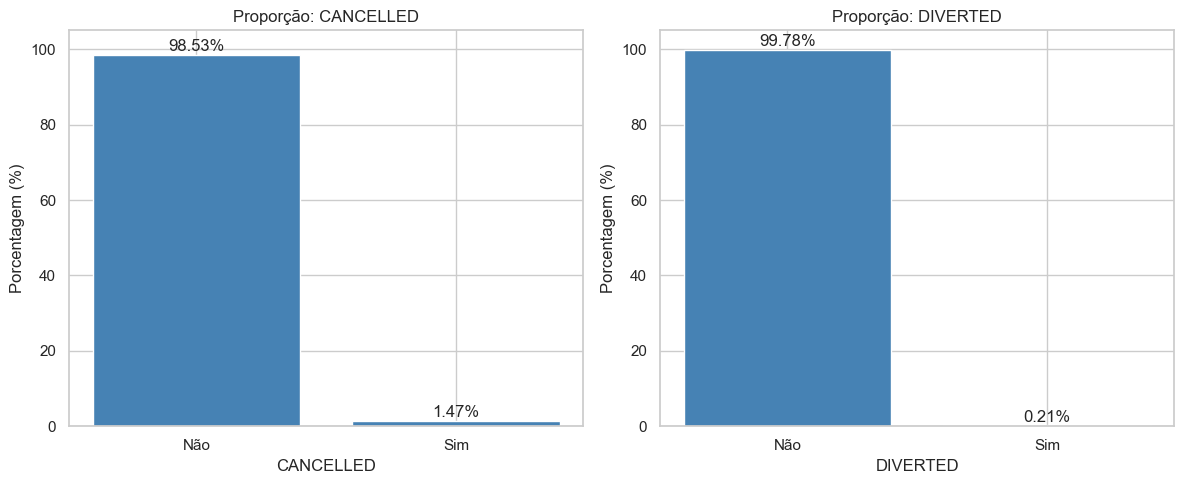

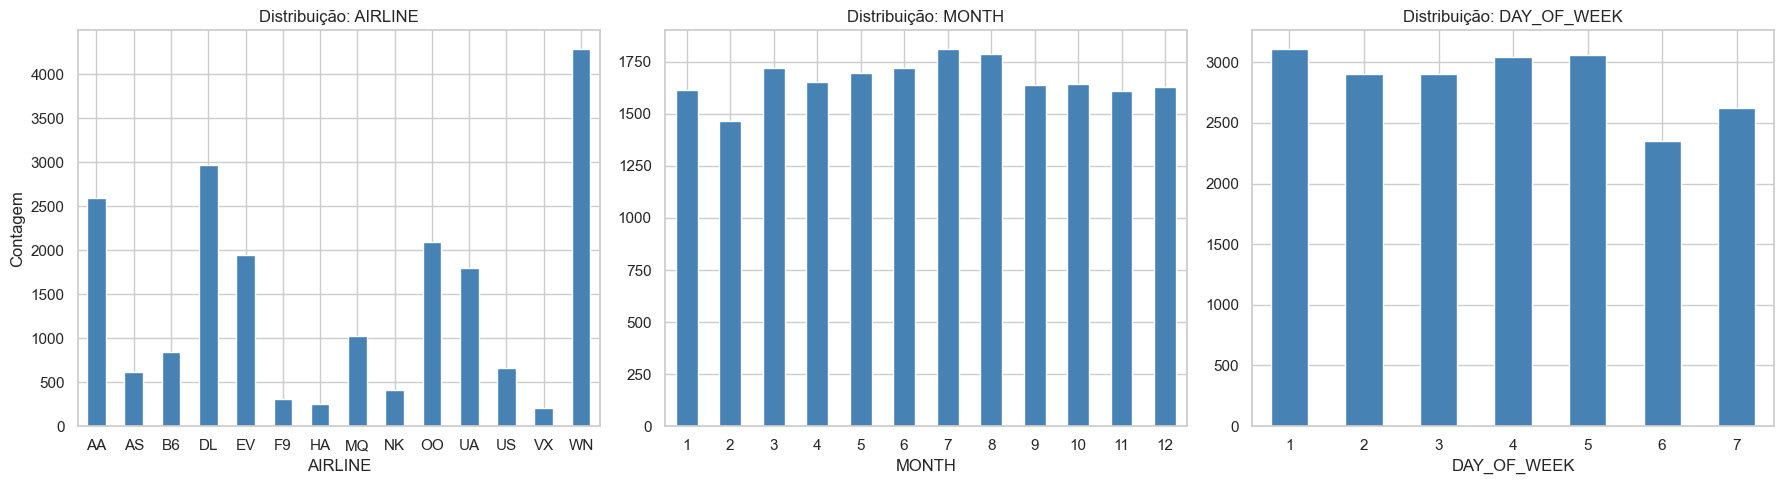

In [65]:
# Função de plot para variáveis binárias
def plot_proporcao_legenda_horizontal(colunas, labels={0: 'Não', 1: 'Sim'}):
    fig, axes = plt.subplots(1, len(colunas), figsize=(12, 5))
    
    for i, coluna in enumerate(colunas):
        proporcao = df[coluna].value_counts(normalize=True).sort_index() * 100
        ax = axes[i]
        bars = ax.bar(range(len(proporcao)), proporcao, color='steelblue')
        
        # Ajusta os rótulos
        ax.set_xticks(range(len(proporcao)))
        ax.set_xticklabels([labels.get(val, str(val)) for val in proporcao.index])
        ax.set_title(f'Proporção: {coluna}')
        ax.set_ylabel('Porcentagem (%)')
        ax.set_xlabel(coluna)
        ax.set_ylim(0, 105)

        # Adiciona porcentagens no topo
        for j, p in enumerate(proporcao):
            ax.text(j, p + 1, f'{p:.2f}%', ha='center')

    plt.tight_layout()
    plt.show()

# Executando para CANCELLED e DIVERTED
plot_proporcao_legenda_horizontal(['CANCELLED', 'DIVERTED'])


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot - AIRLINE
df['AIRLINE'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Distribuição: AIRLINE')
axes[0].set_ylabel('Contagem')
axes[0].set_xlabel('AIRLINE')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Plot - MONTH
df['MONTH'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='steelblue')
axes[1].set_title('Distribuição: MONTH')
axes[1].set_xlabel('MONTH')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

# Plot - DAY_OF_WEEK
df['DAY_OF_WEEK'].value_counts().sort_index().plot(kind='bar', ax=axes[2], color='steelblue')
axes[2].set_title('Distribuição: DAY_OF_WEEK')
axes[2].set_xlabel('DAY_OF_WEEK')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

### **Matriz de Correlação entre Variáveis Numéricas**

A matriz de correlação permite identificar relações lineares entre variáveis numéricas, o que pode revelar redundâncias, associações relevantes ou indícios de colinearidade. 

As correlações mais altas serão investigadas com atenção nas próximas etapas para auxiliar na seleção de variáveis e interpretação dos atrasos.


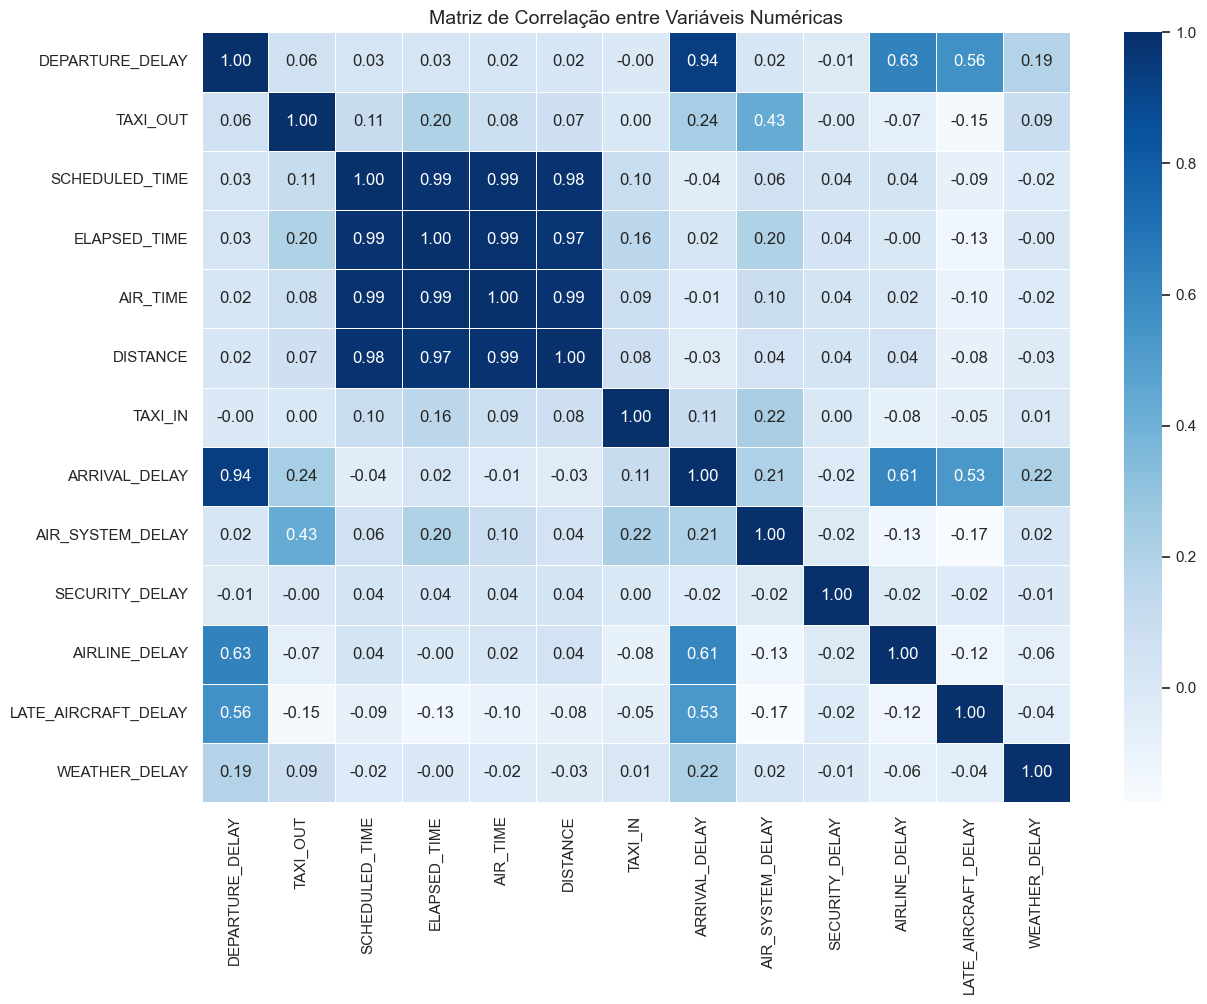

In [66]:
# Filtra apenas colunas numéricas
df_numerico = df.select_dtypes(include=['float64', 'int64'])

# Calcula a matriz de correlação
correlacao = df_numerico.corr()

# Plot do heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlacao, annot=True, fmt=".2f", cmap="Blues", linewidths=0.5)
plt.title("Matriz de Correlação entre Variáveis Numéricas", fontsize=14)
plt.show()


### **Tratamento de Outliers**

Nesta etapa, identifico e trato valores extremos (outliers) em variáveis numéricas que podem impactar negativamente a análise estatística e os modelos preditivos.

Valores atípicos podem ser resultado de erros de medição, registros incomuns ou eventos raros. Em um cenário como o de atrasos em voos, é importante diferenciar **ruídos estatísticos** de **eventos extremos reais**.

A análise será realizada com base nos seguintes pontos:
- Visualização por **boxplots** para variáveis-chave;
- Quantificação via **faixa interquartil (IQR)**;
- Discussão sobre estratégia de tratamento (remoção, truncamento ou manutenção).

Abaixo, apresento os boxplots das principais variáveis contínuas para uma primeira identificação visual dos outliers:


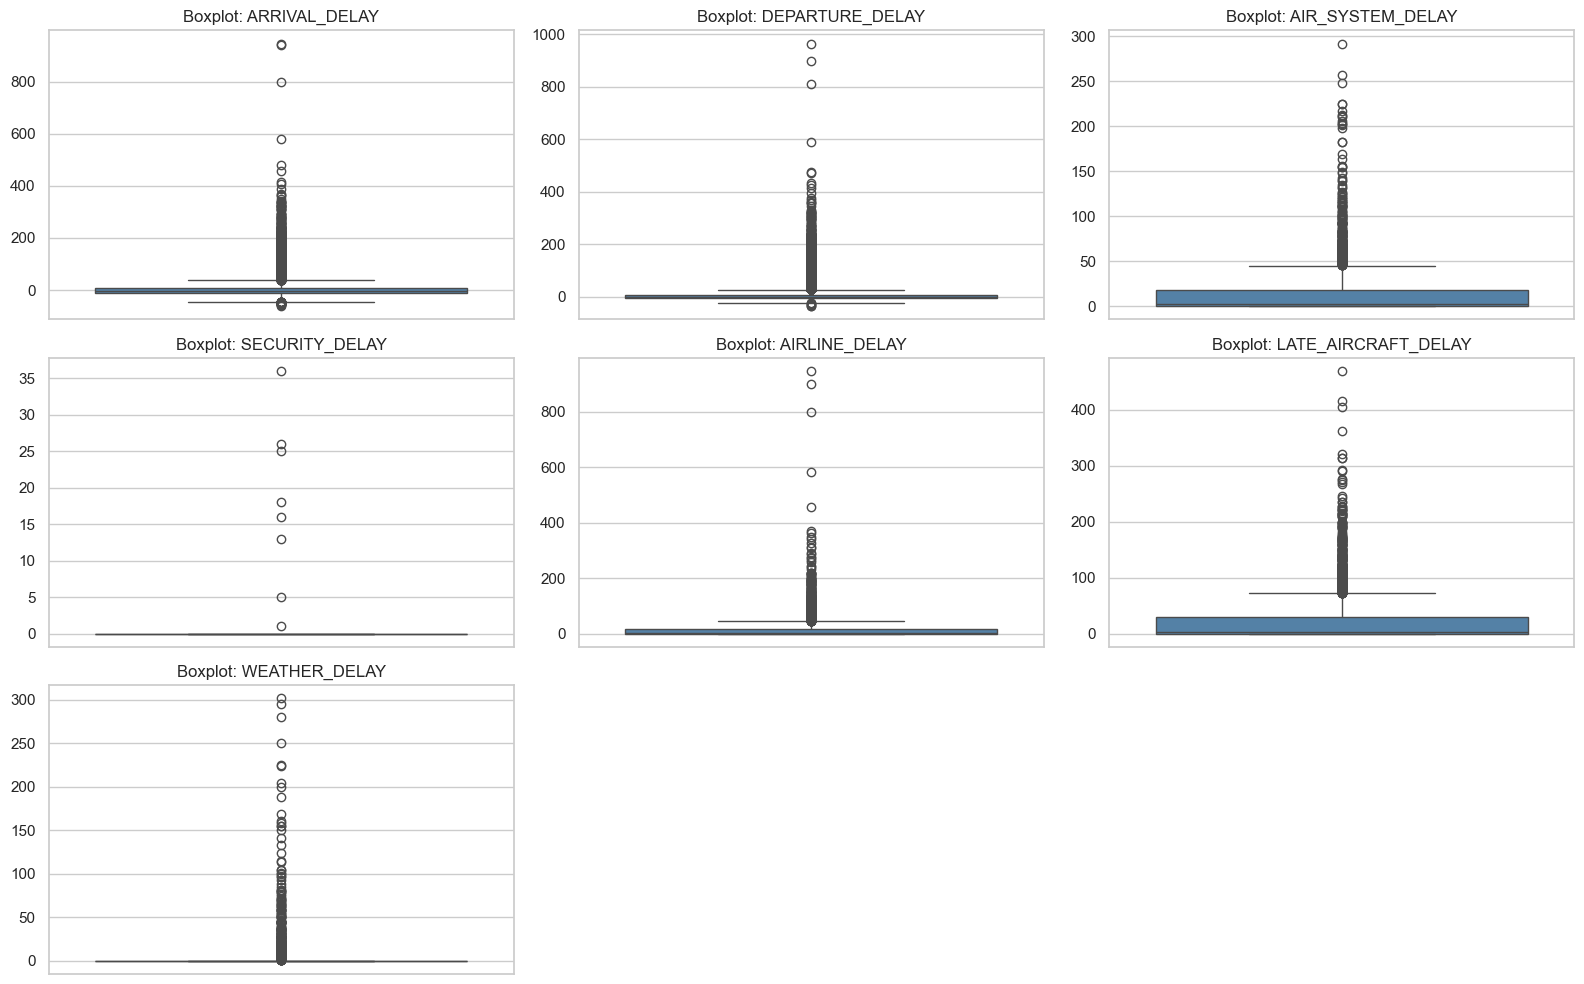

In [67]:
# Variáveis contínuas selecionadas para análise de outliers
variaveis_outliers = [
    'ARRIVAL_DELAY', 'DEPARTURE_DELAY',
    'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
    'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'
]

# Boxplots para visualização
plt.figure(figsize=(16, 10))
for i, coluna in enumerate(variaveis_outliers, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df, y=coluna, color='steelblue')
    plt.title(f'Boxplot: {coluna}')
    plt.ylabel('')

plt.tight_layout()
plt.show()


### **Decisão sobre Tratamento de Outliers**

A análise dos boxplots indicou a presença de valores atípicos (outliers) em todas as variáveis de atraso analisadas. No entanto, esses valores representam eventos reais e críticos na operação aérea, como atrasos severos por clima, manutenção ou problemas logísticos.

Dessa forma, **optou-se por manter os outliers na base de dados**, garantindo a preservação de informações relevantes para a análise. A remoção poderia mascarar situações importantes, comprometendo a interpretação de padrões de atraso.


## **Engenharia de Atributos**

Nesta etapa, o objetivo é **criar novas variáveis derivadas** a partir dos dados originais para melhorar a capacidade explicativa do modelo e capturar padrões não triviais.

A engenharia de atributos é uma etapa crítica para **aumentar o poder preditivo** dos algoritmos de machine learning e garantir uma representação mais rica do fenômeno analisado — neste caso, os atrasos em voos.

Serão aplicadas as seguintes estratégias:
- Extração de informações úteis a partir de colunas temporais (ex: parte do dia, horário de pico);
- Criação de variáveis binárias e categóricas derivadas de atrasos;
- Agrupamento de faixas de tempo ou distância (binning);
- Cálculo de métricas compostas (ex: tempo total em solo).

A seguir, iniciaremos a construção dos primeiros atributos.


In [68]:
# Criação de atributos derivados
df['DEPARTURE_HOUR'] = df['SCHEDULED_DEPARTURE'].apply(lambda x: x.hour if pd.notnull(x) else -1)

# Mapeando período do dia com base na hora
def map_part_of_day(hour):
    if hour == -1:
        return 'Desconhecido'
    elif 5 <= hour < 12:
        return 'Manhã'
    elif 12 <= hour < 17:
        return 'Tarde'
    elif 17 <= hour < 21:
        return 'Noite'
    else:
        return 'Madrugada'

df['PART_OF_DAY'] = df['DEPARTURE_HOUR'].apply(map_part_of_day)

# Total de atraso somando todas as causas conhecidas
df['TOTAL_DELAY'] = df[['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']].sum(axis=1)

# Binarizando variável-alvo (atraso na partida maior que 15 minutos)
df['IS_DELAYED'] = (df['DEPARTURE_DELAY'] > 15).astype(int)

# Agrupando distância em faixas (bins)
bins = [0, 500, 1000, 1500, 2000, 5000]
labels = ['Muito Curta', 'Curta', 'Média', 'Longa', 'Muito Longa']
df['DISTANCE_BIN'] = pd.cut(df['DISTANCE'], bins=bins, labels=labels, include_lowest=True)

# Indicador de final de semana
df['IS_WEEKEND'] = df['DAY_OF_WEEK'].apply(lambda x: x in [6, 7])

# Visualização parcial
df[['SCHEDULED_DEPARTURE', 'DEPARTURE_HOUR', 'PART_OF_DAY', 'DEPARTURE_DELAY', 'IS_DELAYED']].head()


,SCHEDULED_DEPARTURE,DEPARTURE_HOUR,PART_OF_DAY,DEPARTURE_DELAY,IS_DELAYED
0,13:40:00,13,Tarde,-5.0,0
1,19:10:00,19,Noite,-12.0,0
2,06:30:00,6,Manhã,-4.0,0
3,08:10:00,8,Manhã,153.0,1
4,10:00:00,10,Manhã,8.0,0


## **Validação dos Atributos Criados**

Nesta etapa, iremos avaliar a utilidade prática dos atributos derivados durante a engenharia, verificando se eles ajudam a identificar padrões relevantes relacionados aos atrasos. Essa validação é essencial para garantir que as novas variáveis adicionam valor às análises e modelos futuros.

Os principais objetivos são:
- Entender a distribuição dos novos atributos;
- Verificar relações com atrasos (`IS_DELAYED`);
- Confirmar se essas variáveis podem ser úteis para modelagem ou geração de insights.


### **Distribuição de voos por `PART_OF_DAY`**

Vamos verificar como os voos estão distribuídos entre os períodos do dia (`Manhã`, `Tarde`, `Noite`, `Madrugada`, `Desconhecido`). Isso nos ajuda a entender o volume de voos em cada faixa horária e pode antecipar padrões de atraso por turno.

Obs.: A categoria "Desconhecido" aparece por precaução na categorização, mas não possui ocorrências reais no dataset.


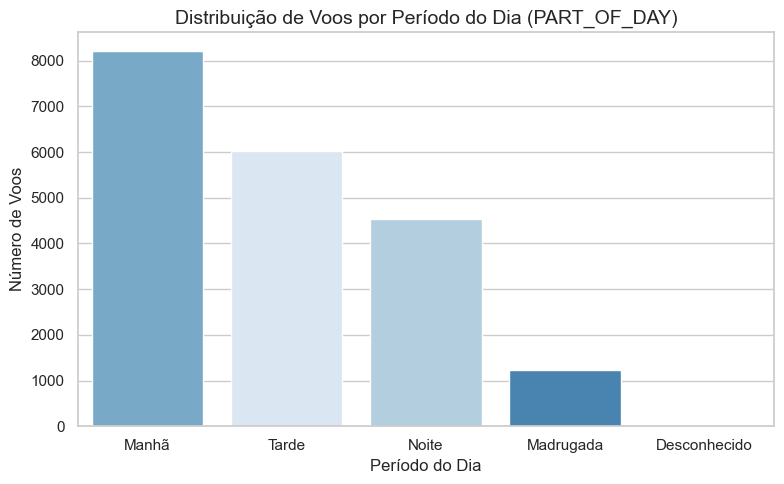

In [78]:
# Distribuição de voos por período do dia (PART_OF_DAY) - versão sem warning
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='PART_OF_DAY', hue='PART_OF_DAY', legend=False, order=df['PART_OF_DAY'].value_counts().index, palette='Blues')

plt.title('Distribuição de Voos por Período do Dia (PART_OF_DAY)', fontsize=14)
plt.xlabel('Período do Dia')
plt.ylabel('Número de Voos')
plt.tight_layout()
plt.show()


### **Criação da Variável: Faixa de Atraso (`DELAY_BUCKET`)**

Nesta subetapa, criarei uma nova variável chamada `DELAY_BUCKET`, que categoriza os voos conforme a gravidade do atraso na decolagem (`DEPARTURE_DELAY`).

Essa categorização ajuda a entender melhor a distribuição dos atrasos e a identificar padrões específicos para atrasos leves, moderados ou severos.

As faixas definidas serão:
- **Sem atraso:** Atrasos negativos ou iguais a zero;
- **Leve:** Atrasos de 1 a 15 minutos;
- **Moderado:** De 16 a 60 minutos;
- **Grave:** Acima de 60 minutos.

Essa variável será útil para análises descritivas, visualizações e possíveis modelagens futuras.


In [79]:
# Função para classificar o atraso
def bucket_atraso(minutos):
    if minutos <= 0:
        return 'Sem atraso'
    elif minutos <= 15:
        return 'Leve'
    elif minutos <= 60:
        return 'Moderado'
    else:
        return 'Grave'

# Criando a nova coluna
df['DELAY_BUCKET'] = df['DEPARTURE_DELAY'].apply(bucket_atraso)

# Verificando as primeiras linhas
df[['DEPARTURE_DELAY', 'DELAY_BUCKET']].head()


,DEPARTURE_DELAY,DELAY_BUCKET
0,-5.0,Sem atraso
1,-12.0,Sem atraso
2,-4.0,Sem atraso
3,153.0,Grave
4,8.0,Leve


### **Análise da Distribuição da Nova Variável `DELAY_BUCKET`**

Agora que criamos a variável `DELAY_BUCKET`, vamos analisar a distribuição das categorias para entender a frequência de cada tipo de atraso. 

Essa análise ajuda a identificar se há predominância de voos sem atraso, atrasos leves, moderados ou graves — o que é essencial para direcionar os próximos passos da análise e modelagem.


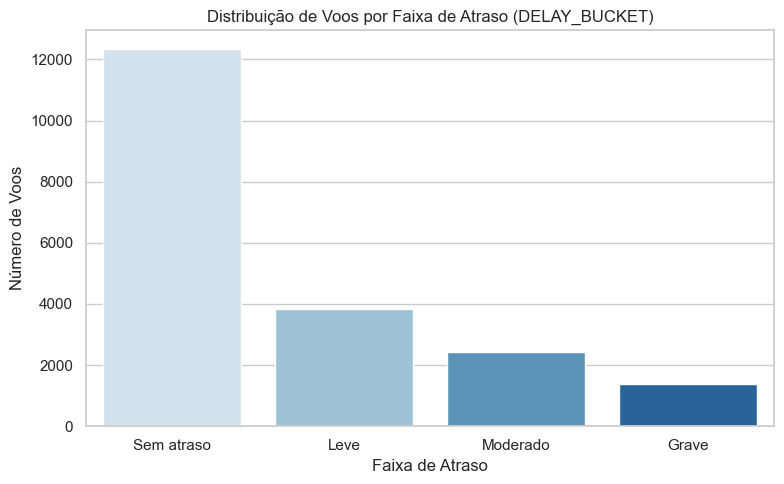

In [80]:
# Analisando a distribuição da nova variável categórica
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='DELAY_BUCKET', order=df['DELAY_BUCKET'].value_counts().index, palette='Blues')
plt.title('Distribuição de Voos por Faixa de Atraso (DELAY_BUCKET)')
plt.xlabel('Faixa de Atraso')
plt.ylabel('Número de Voos')
plt.tight_layout()
plt.show()


### **Criação da Variável de Mês em Texto (`MONTH_NAME`)**

Para facilitar análises sazonais e melhorar a legibilidade dos gráficos, criaremos uma nova variável categórica com o nome do mês a partir da coluna numérica `MONTH`.

Essa transformação é útil para análises temporais e facilita a compreensão de tendências mensais nos atrasos de voo.


In [81]:
# Criando coluna com nome dos meses a partir do número
df['MONTH_NAME'] = df['MONTH'].apply(lambda x: calendar.month_name[x])
df['MONTH_NAME'] = pd.Categorical(df['MONTH_NAME'], categories=calendar.month_name[1:], ordered=True)

# Verificando o resultado
df[['MONTH', 'MONTH_NAME']].head()


,MONTH,MONTH_NAME
0,4,April
1,1,January
2,7,July
3,5,May
4,7,July


### **Distribuição de Voos por Mês (MONTH_NAME)**

Nesta etapa, visualizaremos a distribuição dos voos ao longo dos meses do ano com base na variável `MONTH_NAME`. Essa análise nos permite observar padrões sazonais na quantidade de voos, o que pode ser relevante para identificar períodos com maior ou menor propensão a atrasos.

A visualização será feita por meio de um gráfico de barras ordenado de acordo com o calendário.


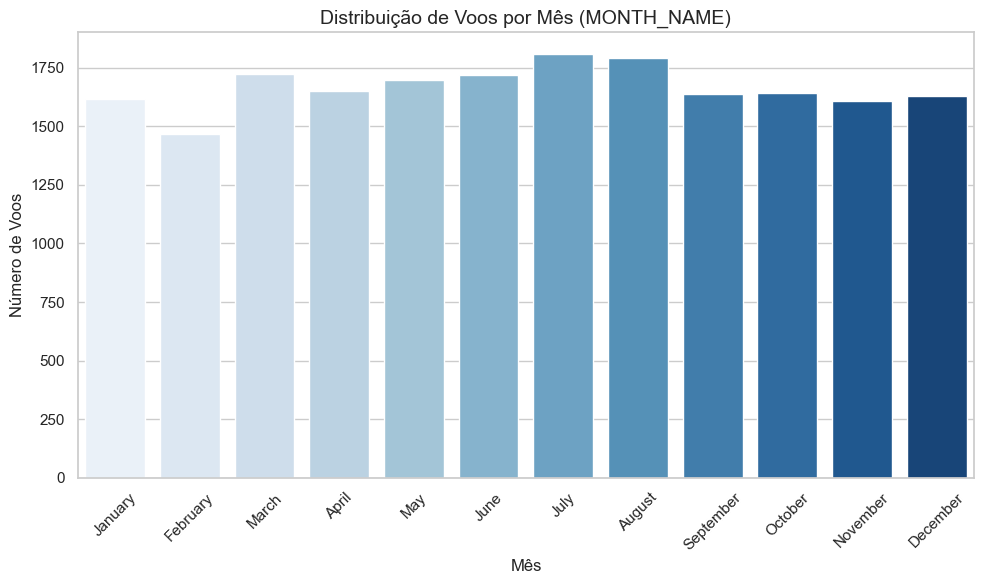

In [82]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='MONTH_NAME', order=calendar.month_name[1:], palette='Blues')
plt.title('Distribuição de Voos por Mês (MONTH_NAME)', fontsize=14)
plt.xlabel('Mês')
plt.ylabel('Número de Voos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### **Distribuição dos Voos por Dia da Semana (DAY_OF_WEEK)**

Nesta subetapa, analisamos a distribuição dos voos ao longo da semana com base na variável `DAY_OF_WEEK`, que representa os dias de 1 (segunda-feira) a 7 (domingo).

Para facilitar a interpretação, será criada uma nova variável chamada `WEEKDAY_NAME`, com os nomes dos dias da semana.

O objetivo é identificar padrões sazonais, como maior volume de voos em determinados dias, o que pode ter implicações relevantes na análise de atrasos.


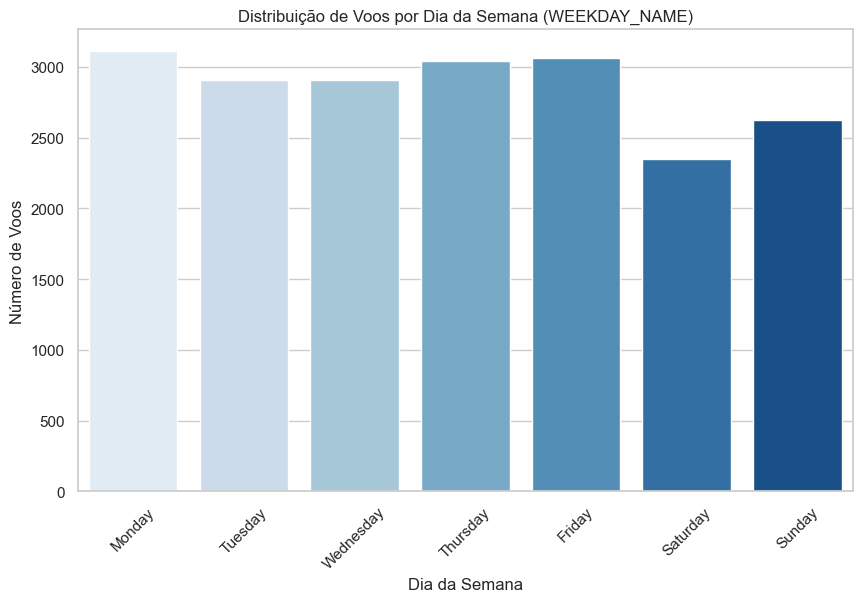

In [83]:
# Criação da coluna com os nomes dos dias da semana
dias_semana = list(calendar.day_name)  # Agora é uma lista válida
df['WEEKDAY_NAME'] = df['DAY_OF_WEEK'].apply(lambda x: dias_semana[x - 1])
df['WEEKDAY_NAME'] = pd.Categorical(df['WEEKDAY_NAME'], categories=dias_semana, ordered=True)

# Plotando a distribuição de voos por dia da semana
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='WEEKDAY_NAME', order=dias_semana, palette='Blues')
plt.title('Distribuição de Voos por Dia da Semana (WEEKDAY_NAME)')
plt.xlabel('Dia da Semana')
plt.ylabel('Número de Voos')
plt.xticks(rotation=45)
plt.show()


### **Distribuição de Voos por Companhia Aérea (AIRLINE)**

Nesta subetapa, exploramos a variável `AIRLINE`, que indica a companhia aérea responsável pelo voo. 

Essa análise é essencial para identificar o volume de voos por companhia, permitindo investigações futuras sobre possíveis diferenças de desempenho, atrasos ou cancelamentos entre as operadoras.

O gráfico de barras nos permitirá visualizar a distribuição de forma clara e objetiva.


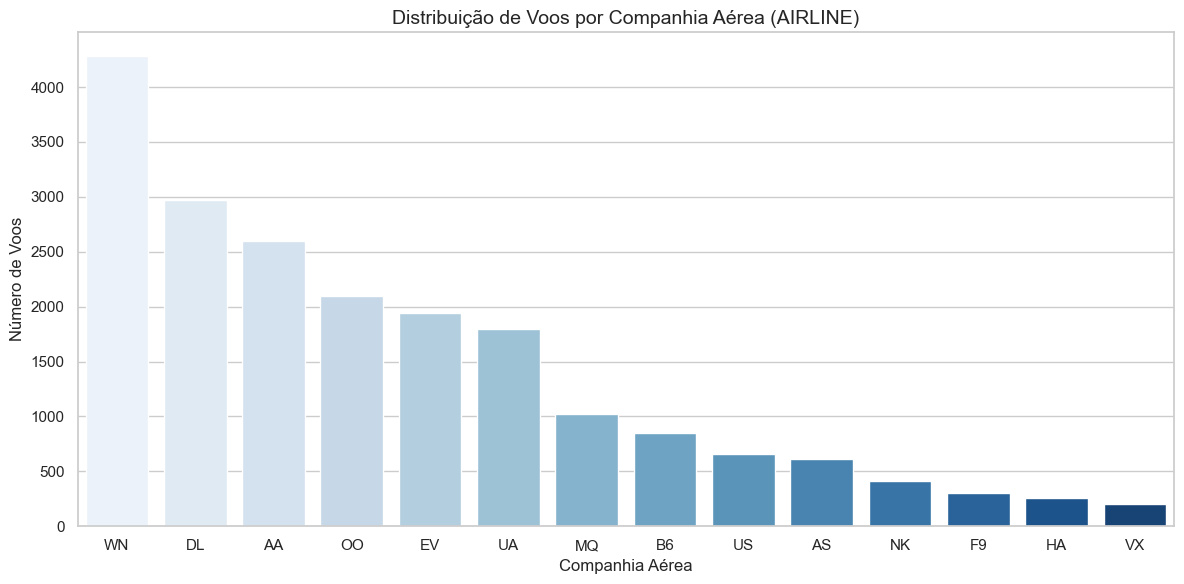

In [84]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='AIRLINE', order=df['AIRLINE'].value_counts().index, palette='Blues')
plt.title('Distribuição de Voos por Companhia Aérea (AIRLINE)', fontsize=14)
plt.xlabel('Companhia Aérea')
plt.ylabel('Número de Voos')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### **Distribuição dos 10 Principais Aeroportos de Origem**

Nesta subetapa, analisamos os aeroportos com maior volume de voos. A visualização revela os 10 aeroportos de origem mais movimentados da base de dados, permitindo compreender a concentração de voos em hubs logísticos e possíveis implicações na previsão de atrasos.

Essa análise contribui para a identificação de padrões operacionais e possíveis gargalos no sistema aéreo, e será levada em conta durante a etapa de modelagem.

A seguir, o gráfico mostra os aeroportos com maior número de partidas registradas.


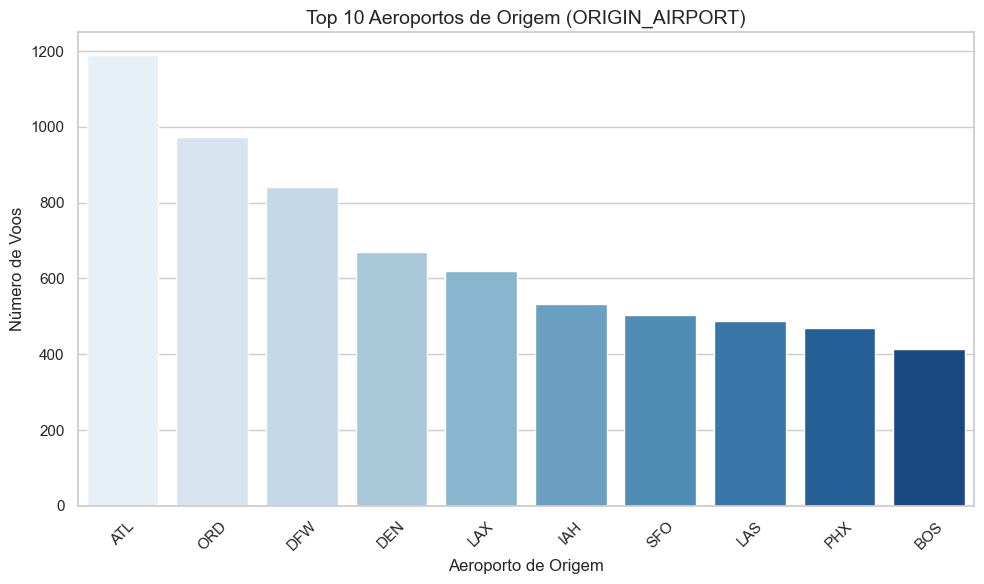

In [85]:
# ### Distribuição dos 10 Principais Aeroportos de Origem (ORIGIN_AIRPORT)
top_origin_airports = df['ORIGIN_AIRPORT'].value_counts().nlargest(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_origin_airports.index, y=top_origin_airports.values, palette='Blues')
plt.title("Top 10 Aeroportos de Origem (ORIGIN_AIRPORT)", fontsize=14)
plt.xlabel("Aeroporto de Origem")
plt.ylabel("Número de Voos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## **Pré-processamento para Modelagem**

Antes de aplicar os algoritmos de machine learning, é necessário preparar os dados de forma adequada. Essa etapa envolve:

- **Codificação de variáveis categóricas:** transforma valores categóricos em representações numéricas que os modelos conseguem interpretar.
- **Separação das variáveis independentes (features) e da variável dependente (target)**.
- **Divisão da base em treino e teste**, garantindo que a amostra de teste represente bem o comportamento dos dados.

Este pré-processamento garante que o modelo seja treinado de forma robusta e avaliado corretamente.


In [87]:
from sklearn.model_selection import train_test_split

# Codificação de variáveis categóricas com get_dummies
df_encoded = pd.get_dummies(df, drop_first=True)

# Separação de variáveis independentes (X) e dependente (y)
X = df_encoded.drop('IS_DELAYED', axis=1)
y = df_encoded['IS_DELAYED']

# Divisão treino/teste com estratificação para manter a proporção de atrasos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Verificação das dimensões resultantes
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((16000, 17695), (4000, 17695), (16000,), (4000,))

### **Balanceamento do Target**

Antes de seguir com a modelagem, é importante verificar se há desbalanceamento entre as classes da variável alvo `IS_DELAYED`.

Um desbalanceamento acentuado pode fazer com que os modelos de classificação aprendam a prever apenas a classe majoritária. Caso detectado, serão consideradas técnicas de balanceamento como:
- **Subamostragem** da classe majoritária,
- **Oversampling** da classe minoritária (ex: SMOTE).

A seguir, visualizo a distribuição da variável alvo nos conjuntos de treino e teste.


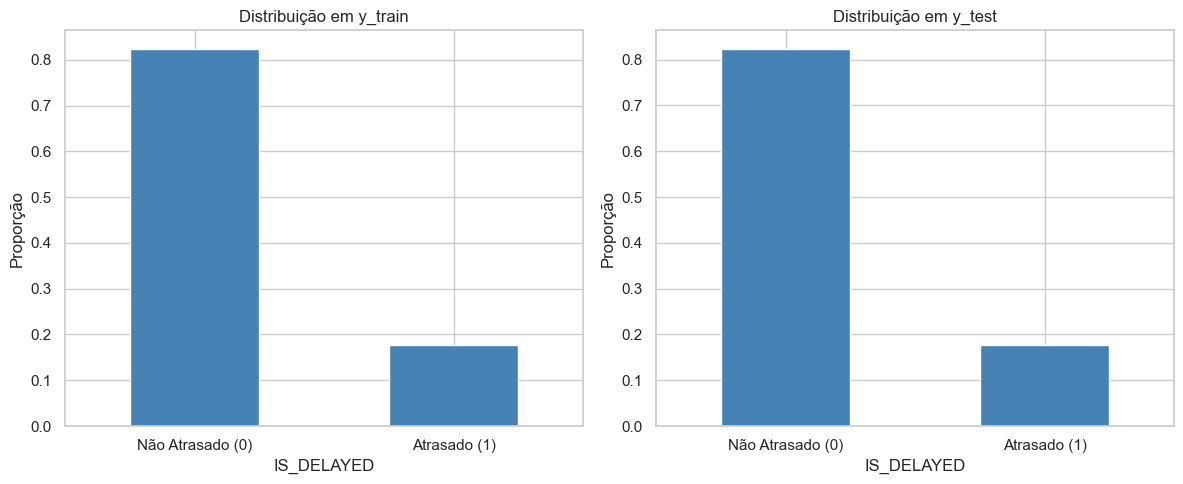

In [88]:
# Distribuição da variável alvo no treino e teste
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Treino
y_train.value_counts(normalize=True).plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Distribuição em y_train')
axes[0].set_xlabel('IS_DELAYED')
axes[0].set_ylabel('Proporção')
axes[0].set_xticklabels(['Não Atrasado (0)', 'Atrasado (1)'], rotation=0)

# Teste
y_test.value_counts(normalize=True).plot(kind='bar', ax=axes[1], color='steelblue')
axes[1].set_title('Distribuição em y_test')
axes[1].set_xlabel('IS_DELAYED')
axes[1].set_ylabel('Proporção')
axes[1].set_xticklabels(['Não Atrasado (0)', 'Atrasado (1)'], rotation=0)

plt.tight_layout()
plt.show()


### **Seleção de Variáveis Relevantes**

A escolha adequada de variáveis é essencial para garantir a qualidade da modelagem, evitando ruídos, redundâncias e colinearidades que podem afetar a performance.

Nesta etapa:
- Removeremos colunas que não agregam valor preditivo (como identificadores e colunas redundantes),
- Verificaremos a presença de variáveis altamente correlacionadas,
- E prepararemos o dataset final para treino e teste.

Critérios:
- Colunas como `SCHEDULED_DEPARTURE` (horário completo), `DELAY_BUCKET` e `PART_OF_DAY` serão excluídas por já estarem representadas em variáveis derivadas (`DEPARTURE_HOUR`, `IS_DELAYED`, etc.).


In [89]:
# Verificando as colunas atuais
print("Colunas atuais:", X_train.columns.tolist())

# Definindo colunas para remover
cols_to_remove = ['SCHEDULED_DEPARTURE', 'PART_OF_DAY', 'DELAY_BUCKET']

# Aplicando a remoção
X_train = X_train.drop(columns=cols_to_remove, errors='ignore')
X_test = X_test.drop(columns=cols_to_remove, errors='ignore')

print("\nColunas após remoção:", X_train.columns.tolist())


Colunas atuais: ['DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'TAXI_IN', 'ARRIVAL_DELAY', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'DEPARTURE_HOUR', 'TOTAL_DELAY', 'IS_WEEKEND', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12', 'DAY_2', 'DAY_3', 'DAY_4', 'DAY_5', 'DAY_6', 'DAY_7', 'DAY_8', 'DAY_9', 'DAY_10', 'DAY_11', 'DAY_12', 'DAY_13', 'DAY_14', 'DAY_15', 'DAY_16', 'DAY_17', 'DAY_18', 'DAY_19', 'DAY_20', 'DAY_21', 'DAY_22', 'DAY_23', 'DAY_24', 'DAY_25', 'DAY_26', 'DAY_27', 'DAY_28', 'DAY_29', 'DAY_30', 'DAY_31', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4', 'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'DAY_OF_WEEK_7', 'AIRLINE_AS', 'AIRLINE_B6', 'AIRLINE_DL', 'AIRLINE_EV', 'AIRLINE_F9', 'AIRLINE_HA', 'AIRLINE_MQ', 'AIRLINE_NK', 'AIRLINE_OO', 'AIRLINE_UA', 'AIRLINE_US', 'AIRLINE_VX', 'AIRLINE_WN', 'FLIGHT_NUMBER_10', 'FLI

### **Codificação de Variáveis Categóricas**

Modelos de machine learning geralmente exigem que todas as variáveis estejam em formato numérico. Por isso, realizaremos a codificação das variáveis categóricas presentes no conjunto de dados.

Serão utilizadas as seguintes estratégias:

- **One-Hot Encoding** para variáveis com poucas categorias (como dias da semana e companhias aéreas);
- **Remoção de colunas duplicadas** após codificação para evitar multicolinearidade.


In [90]:
# Identificando colunas categóricas
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
print("Variáveis categóricas a codificar:", categorical_cols)

# Aplicando One-Hot Encoding
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Garantindo que ambas as bases tenham as mesmas colunas
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# Substituindo as variáveis codificadas nos datasets
X_train = X_train_encoded
X_test = X_test_encoded

print(f"Formato final do X_train: {X_train.shape}")
print(f"Formato final do X_test: {X_test.shape}")


Variáveis categóricas a codificar: []
Formato final do X_train: (16000, 17695)
Formato final do X_test: (4000, 17695)


### **Padronização das Variáveis Numéricas**

Nesta etapa, aplicaremos a padronização dos dados para garantir que todas as variáveis numéricas estejam na mesma escala. Isso é especialmente importante para algoritmos sensíveis à magnitude dos dados, como Regressão Logística e SVM.

Utilizaremos o `StandardScaler` da biblioteca `sklearn`, que transforma os dados para que tenham média 0 e desvio padrão 1.


In [91]:
from sklearn.preprocessing import StandardScaler

# Instancia o scaler
scaler = StandardScaler()

# Ajusta o scaler com os dados de treino e transforma ambos os conjuntos
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Exibindo os novos shapes e tipo
print("Shape de X_train_scaled:", X_train_scaled.shape)
print("Shape de X_test_scaled:", X_test_scaled.shape)


Shape de X_train_scaled: (16000, 17695)
Shape de X_test_scaled: (4000, 17695)
